## Imports

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

%cd /content/drive/MyDrive/GRM_proj/

Mounted at /content/drive
/content/drive/MyDrive/GRM_proj


In [ ]:
!pip install PyMaxFlow

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
import scipy as sp

from src.energy import cluster_style
from src.energy import data_energy
from src.energy import feature_WCT
from src.energy import style_transfer

#import graph_cut as gc
from maxflow.fastmin import aexpansion_grid

Content shape :  (128, 128, 3)
Style shape :  (128, 128, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


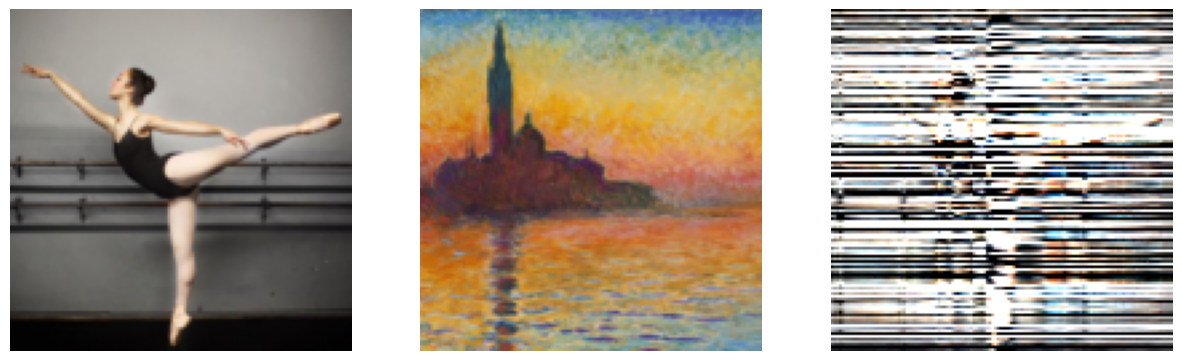

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name, for_plot=True):
    image = Image.open(image_name)
    image =  loader(image).unsqueeze(0).to(device, torch.float)[:, :3][0]
    if for_plot:
      image = image.cpu().numpy().transpose(1,2,0)
    return image

content_img = image_loader("data/images/dance2.png")
style_img = image_loader("data/images/monnet.png")

print("Content shape : ",content_img.shape)
print("Style shape : ",style_img.shape)


def plot_images(target, initial, assigned):
    """shows both images"""

    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(target)
    ax[0].axis('off')
    ax[1].imshow(initial)
    ax[1].axis('off')
    ax[2].imshow(assigned)
    ax[2].axis('off')

    plt.show();

transfered_features = style_transfer(content_img, style_img, k =2)

plot_images(content_img, style_img, transfered_features)

Distance array shape :  (3, 128, 128)
Distance image shape :  (128, 128)


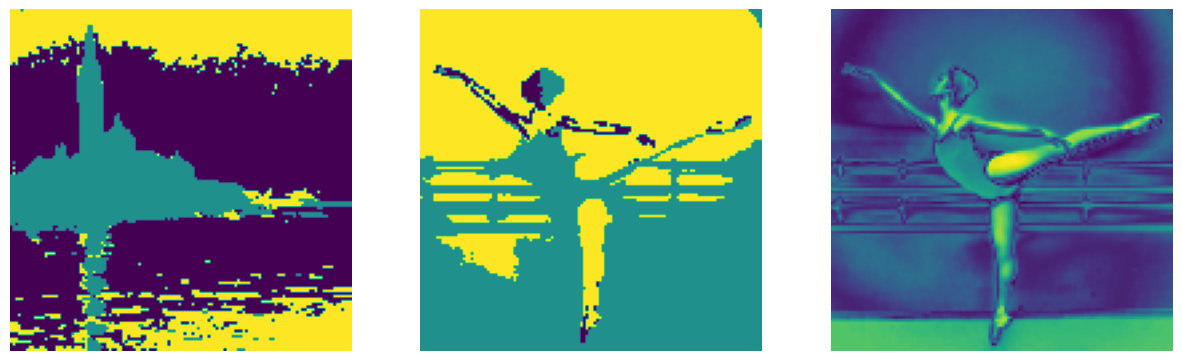

In [ ]:
#clustering of style image
n_clusters=3

style_img_flat = style_img.reshape((-1,3))
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(style_img_flat)

cluster_labels = kmeans.labels_.reshape((imsize,imsize))
cluster_centers = kmeans.cluster_centers_

# distance of content image to cluster centers

distance_array = np.zeros((n_clusters,imsize,imsize), dtype=np.float32)
print("Distance array shape : ",distance_array.shape)

for i, cluster_center in enumerate(cluster_centers):
    distances = np.linalg.norm(content_img - cluster_center, axis=2)
    distance_array[i] = distances


#greedy assignement
greedy_assignments = np.argmin(distance_array,axis=0)
distance_img = np.zeros((imsize,imsize),dtype=np.float32)
print("Distance image shape : ",distance_img.shape)

for i, cluster_center in enumerate(cluster_centers):
    mask = (greedy_assignments == i)
    distance_img[mask] = distance_array[i][mask]

plot_images(cluster_labels, greedy_assignments, distance_img)

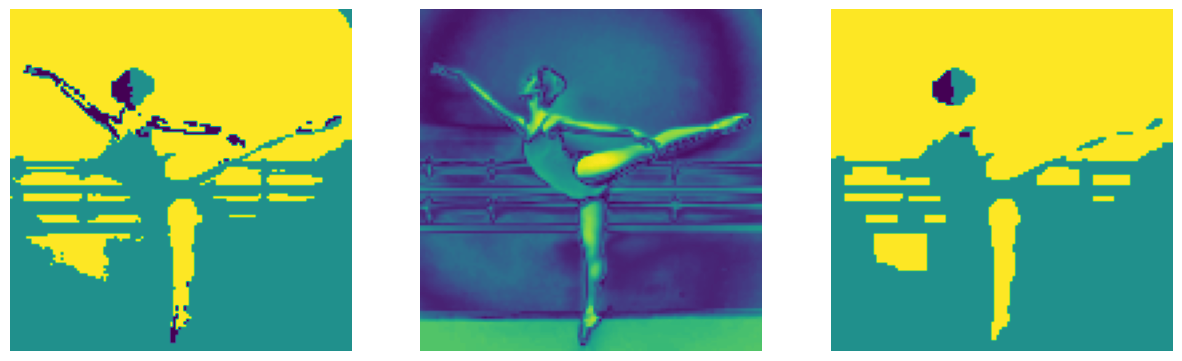

In [ ]:
beta = 0.1
smooth_term = beta * (1 - np.eye(n_clusters))
data_term = distance_array.transpose(1,2,0).copy().astype(np.double)

new_assignements = aexpansion_grid(data_term, smooth_term, max_cycles=None)

plot_images(greedy_assignments, distance_img, new_assignements)

[(9329, 3), (2924, 3), (4131, 3)]


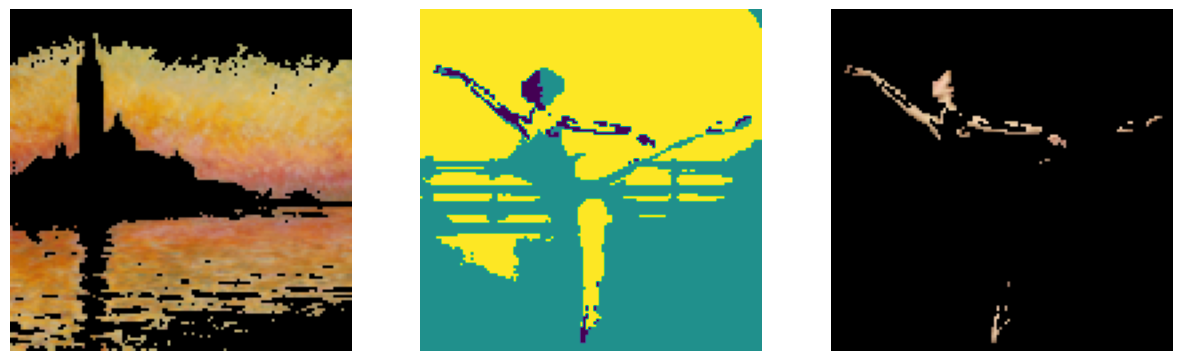

In [ ]:
cluster_list = [style_img[cluster_labels == i] for i in range(n_clusters)]
print([cluster_list[i].shape for i in range(n_clusters)])

cluster_0_style_mask = (cluster_labels == 0)
cluster_0_content_mask = (greedy_assignments == 0)

plot_images((style_img.transpose(2,0,1) * cluster_0_style_mask).transpose(1,2,0), greedy_assignments,(content_img.transpose(2,0,1) * cluster_0_content_mask).transpose(1,2,0))

In [ ]:
alpha = 0.3

transfered_features = np.zeros(content_img.transpose(2,0,1).shape)
print("Transferd shape :", transfered_features.shape)
for i in tqdm(range(3)):
    mask = (cluster_labels == i).astype(int) # (height, width)
    print(content_img.shape)
    print(cluster_list[i].shape)
    transfered_features += feature_WCT(content_img.transpose(2,0,1), cluster_list[i], mask, 0.3)

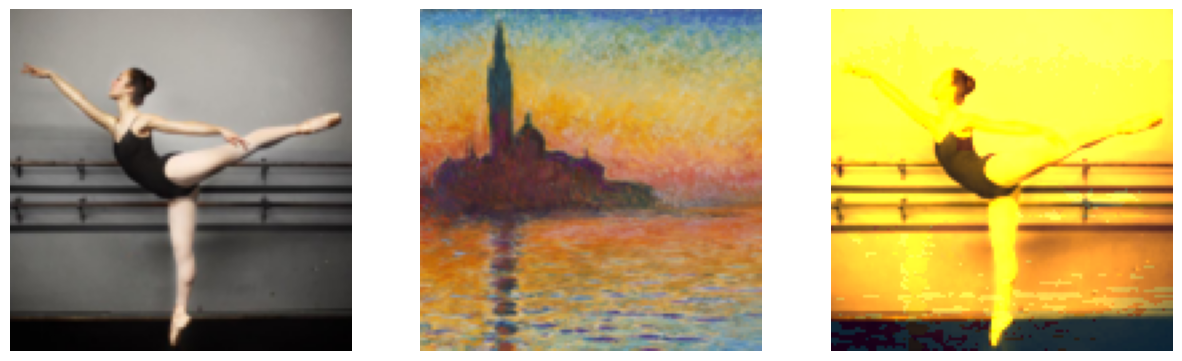

In [ ]:
plot_images(content_img, style_img, transfered_features.transpose(1,2,0))